In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras import constraints
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# import shap
import numpy as np
import time
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import MaxNLocator
from sklearn.utils import class_weight

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import nvidia_smi

# nvidia_smi.nvmlInit()
# handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
# print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
print(tf.__version__)
print(tf.keras.__version__)
# print(keras.__version__)

2.9.2
2.9.0


In [6]:
# fix random seed for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
seed = 85497648
# seed = 963852741
np.random.seed(seed)
random.seed(123)

NUM_PARALLEL_EXEC_UNITS = 4
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS, inter_op_parallelism_threads=2,
                              allow_soft_placement=True, device_count={'CPU': NUM_PARALLEL_EXEC_UNITS})

tf.random.set_seed(123)

sess = tf.compat.v1.Session(config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

os.environ["OMP_NUM_THREADS"] = str(NUM_PARALLEL_EXEC_UNITS)

os.environ["KMP_BLOCKTIME"] = "30"

os.environ["KMP_SETTINGS"] = "1"

os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"

# Rest of code follows ...

In [7]:
# extract test data
rlist = np.load('/content/drive/MyDrive/dataset-events/Events_real_Train_data_GAN_simetrico.npz', allow_pickle=True)
X_train = rlist['data']
Train_label = rlist['label']

In [8]:
unique, counts = np.unique(Train_label, return_counts=True)
Cont = dict(zip(unique, counts))
print(Cont)

{0: 16007, 1: 16007}


In [ ]:
# # random.seed(1)

# num_events = range(len(Train_datafreqT))
# print(num_events)

# print(Train_datafreqT.shape)
# print(Train_datafreqT[0].shape)

In [9]:
# X_train = np.load('/content/drive/MyDrive/dataset-events/Real_time_analise_CD2.npy') # load
print(X_train.shape)
print(X_train[0])

print('train:')
print(len(X_train))

scaler = StandardScaler()
# print(scaler.fit(X_train))

# print(scaler.mean_)

for i in range(0,len(X_train)):
    X_train[i] = scaler.fit_transform(X_train[i,:,:])

X_train = X_train[:,:289,:]

print(X_train.shape)
print(X_train[0])

print('train:')
print(len(X_train))

(32014, 289, 24)
[[60.022402   60.021738   60.022218   ... 60.021957   60.0218193
  60.0218193 ]
 [60.022454   60.021738   60.020574   ... 60.012234   60.02157361
  60.02157361]
 [60.022618   60.021738   60.018581   ... 60.033939   60.02238574
  60.02238574]
 ...
 [60.015022   60.015001   60.017996   ... 60.018143   60.01570183
  60.01570183]
 [60.014655   60.015123   60.018972   ... 60.010517   60.01586335
  60.01586335]
 [60.014245   60.016088   60.016055   ... 60.015614   60.01584409
  60.01584409]]
train:
32014
(32014, 289, 24)
[[ 1.74354012  1.29308249  1.06618162 ...  1.00646132  1.64769454
   1.64769454]
 [ 1.7657319   1.29308249  0.61064169 ... -1.47363894  1.53586638
   1.53586638]
 [ 1.83572135  1.29308249  0.05839651 ...  4.06277741  1.90550682
   1.90550682]
 ...
 [-1.40598528 -1.30336831 -0.10370256 ...  0.0336029  -1.13667022
  -1.13667022]
 [-1.56260802 -1.25634931  0.16673964 ... -1.91160378 -1.06315374
  -1.06315374]
 [-1.73758166 -0.88443673 -0.64153893 ... -0.6114833

In [10]:
Y_train = [int(i) for i in Train_label]


# class_weights = dict(zip(np.unique(Y_train), class_weight.compute_class_weight('balanced',
#                                                  np.unique(Y_train),
#                                                  Y_train))) 

# print(class_weights)

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=2)

In [11]:
rlist = np.load('/content/drive/MyDrive/dataset-events/Events_real_Val_data_GAN_simetrico.npz', allow_pickle=True)
X_val = rlist['data']
Val_label = rlist['label']

In [ ]:
# testX = Val_datafreqT[1236]
# print(testX)

In [12]:
# X_val = np.load('/content/drive/MyDrive/dataset-events/ValX_real_time_analise_CD2.npy') # load
print(X_val.shape)
print(X_val[0])

print('val:')
print(len(X_val))

scaler = StandardScaler()

for i in range(0,len(X_val)):
    X_val[i] = scaler.fit_transform(X_val[i,:,:])

X_val = X_val[:,:289,:]

print(X_val.shape)
print(X_val[0])

print('train:')
print(len(X_val))

(8002, 289, 24)
[[60.008299   60.009247   60.009247   ... 60.009247   60.009247
  60.010918  ]
 [60.007538   60.00723887 60.00723887 ... 60.00723887 60.00723887
  60.004087  ]
 [60.0086     60.00688553 60.00688553 ... 60.00688553 60.00688553
  60.002889  ]
 ...
 [59.876544   59.875902   59.875902   ... 59.875902   59.875902
  59.876663  ]
 [59.876005   59.87609253 59.87609253 ... 59.87609253 59.87609253
  59.877738  ]
 [59.873883   59.87634167 59.87634167 ... 59.87634167 59.87634167
  59.87755   ]]
val:
8002
(8002, 289, 24)
[[ 1.92328241  1.92994624  1.92994624 ...  1.92994624  1.92994624
   2.11913841]
 [ 1.90415655  1.87924089  1.87924089 ...  1.87924089  1.87924089
   1.9380529 ]
 [ 1.9308473   1.87031923  1.87031923 ...  1.87031923  1.87031923
   1.90629467]
 ...
 [-1.38805375 -1.43701338 -1.43701338 ... -1.43701338 -1.43701338
  -1.43987723]
 [-1.40160018 -1.43220242 -1.43220242 ... -1.43220242 -1.43220242
  -1.41137966]
 [-1.45493141 -1.4259118  -1.4259118  ... -1.4259118  -1.425

In [13]:
unique, counts = np.unique(Val_label, return_counts=True)
Cont = dict(zip(unique, counts))
print(Cont)

{0: 4001, 1: 4001}


In [14]:
Y_val = [int(i) for i in Val_label]
Y_val = tf.keras.utils.to_categorical(Y_val, num_classes=2)

In [ ]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [15]:
batch_size =32 #* tpu_strategy.num_replicas_in_sync
num_classes = 2
nb_epoch = 250

# input image dimensions
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

print(img_rows)
print(img_cols)
print(batch_size)

289
24
32


In [16]:

if K.image_data_format() == 'channels_first':
    trainX_arr = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    valX_arr = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    print('channels_first')
    
else:
    trainX_arr = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    valX_arr = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

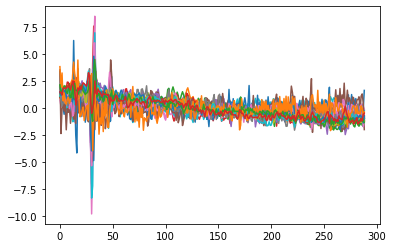

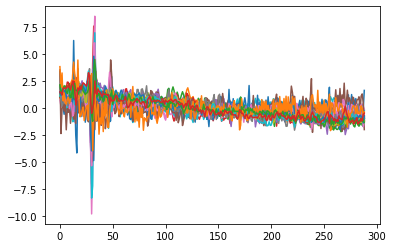

In [17]:
X = trainX_arr[27,:,:,0]

plt.plot(X)
plt.show()


X = X_train[27,:,:]

plt.plot(X)
plt.show()

In [18]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop',neuro1=256,neuro2=128,neuro3=128, neuron_drop=100, drop_rate=0.4,dropout_rate_1=0.3,dropout_rate_2=0.4,dropout_rate_3=0.9, momentum=0.55, flag=True, lo=5e-3, decay=1e-7):
    
    model = Sequential()
    model.add(Conv2D(neuro1, kernel_size=(3, 3),
#                      kernel_constraint=constraints.max_norm(3.0),
                     # activation=None,
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu,
                     input_shape=input_shape))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate_1, seed=66))
    
    model.add(Conv2D(neuro2, kernel_size=(3, 3),
#                      kernel_constraint=constraints.max_norm(3.0),
                     # activation=None,
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    # model.add(Activation(tf.nn.relu))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate_2, seed=66))
    
    model.add(Conv2D(neuro3, kernel_size=(3, 3),
#                      kernel_constraint=constraints.max_norm(3.0),
                     # activation=None,
                     kernel_initializer=initializers.glorot_uniform(seed=66),
                     activation=tf.nn.relu))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    # model.add(Activation(tf.nn.relu))

    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate_3, seed=66))
    
    model.add(Flatten())
    
    model.add(Dense(neuron_drop,
#                     kernel_constraint=constraints.max_norm(3.0),
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    activation=tf.nn.relu))
                    # activation=None
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    # model.add(Activation(tf.nn.relu))
    model.add(Dropout(drop_rate, seed=66))
    
    model.add(Dense(num_classes,
                    kernel_initializer=initializers.glorot_uniform(seed=66),
                    # kernel_constraint=constraints.max_norm(2.0),
                    activation=None))
    model.add(BatchNormalization(momentum=momentum, scale=flag, center=flag))
    model.add(Activation('softmax'))

    # print(model.summary())

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=lo, rho=0.99, epsilon=None, decay=decay),
                  # optimizer = optimizer,
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
                  # metrics=['accuracy'])
    
    # plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    return model

In [ ]:
# unique, counts = np.unique(Train_label, return_counts=True)
# Cont = dict(zip(unique, counts))
# print(Cont)

# j=0
# id_true_events = list()

# for i in range(0,Train_label.shape[0]):
#     if (Train_label[i] == '1'):
#         id_true_events.append(i)   
# print(id_true_events)

# false_events = list()
# True_events = list()
# label_false_events = list()
# label_True_events = list()



# contador = 0
# for i in range(0, len(trainX_arr)):
#   if i in id_true_events:
#     contador += 1 
#     True_events.append(trainX_arr[i])
#     label_True_events.append(1)
#     label_false_events.append(0)
#   else:
#     false_events.append(trainX_arr[i])
    

# print(contador)

# test = random.sample(false_events,contador)

# print(len(test))

# True_events.extend(test)
# label_True_events.extend(label_false_events)

# d = list(zip(True_events, label_True_events))

# random.shuffle(d)

# x_train, y_label= zip(*d)

# trainX_arr_ot = np.array(x_train)

# print(len(x_train))

# Y_train_ot = tf.keras.utils.to_categorical(y_label, num_classes=2)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier


# kmodel = KerasClassifier(build_fn=create_model, verbose=1)


In [ ]:
# batch_size = [40,45,50,55]
# epochs = [100,150,180,200,230,250,260,280,300]

# optimizer = [ 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# dropout_rate = [ 0.3, 0.5, 0.6, 0.8, 0.9]
# drop_rate= [ 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# lr = [1e-6,1e-5,1e-4,1e-3,5e-3,1e-2,1e-1]
# decay = [1e-7,1e-6,1e-5,1e-4,1e-3,5e-3,1e-2,1e-1]
# neuro = [32,64,128,256,512,1024]
# neuro_1 = [10,30,40,60,80,100]

# momentum= [0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.85]
# # rho = [0.6,0.65,0.7,0.75,0.8]
# param_grid = dict(batch_size=batch_size, epochs=epochs)

# grid = GridSearchCV(estimator=kmodel, 
#                     param_grid=param_grid,
#                     n_jobs=1, cv=4)
# grid_result = grid.fit(trainX_arr_ot,Y_train_ot)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

In [20]:
# best model
# with tpu_strategy.scope():
model = create_model()


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 287, 22, 256)      2560      
                                                                 
 batch_normalization (BatchN  (None, 287, 22, 256)     1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 11, 256)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 144, 11, 256)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 9, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 142, 9, 128)      5

In [ ]:
# from IPython.display import Image
# display(Image('model_plot.png', width=500, height=10))

In [22]:
time_start = time.time()

history = model.fit(trainX_arr,Y_train, epochs=nb_epoch, batch_size=batch_size, verbose=2)
time_elapsed = (time.time() - time_start)

print('elapsed time best model (min):', time_elapsed / 60)


Epoch 1/250
1001/1001 - 58s - loss: 0.3471 - categorical_accuracy: 0.8587 - 58s/epoch - 58ms/step
Epoch 2/250
1001/1001 - 45s - loss: 0.2829 - categorical_accuracy: 0.8875 - 45s/epoch - 45ms/step
Epoch 3/250
1001/1001 - 45s - loss: 0.2629 - categorical_accuracy: 0.8951 - 45s/epoch - 45ms/step
Epoch 4/250
1001/1001 - 46s - loss: 0.2498 - categorical_accuracy: 0.9012 - 46s/epoch - 46ms/step
Epoch 5/250
1001/1001 - 46s - loss: 0.2433 - categorical_accuracy: 0.9039 - 46s/epoch - 46ms/step
Epoch 6/250
1001/1001 - 46s - loss: 0.2375 - categorical_accuracy: 0.9064 - 46s/epoch - 46ms/step
Epoch 7/250
1001/1001 - 46s - loss: 0.2316 - categorical_accuracy: 0.9083 - 46s/epoch - 46ms/step
Epoch 8/250
1001/1001 - 46s - loss: 0.2298 - categorical_accuracy: 0.9105 - 46s/epoch - 46ms/step
Epoch 9/250
1001/1001 - 46s - loss: 0.2250 - categorical_accuracy: 0.9113 - 46s/epoch - 46ms/step
Epoch 10/250
1001/1001 - 46s - loss: 0.2226 - categorical_accuracy: 0.9117 - 46s/epoch - 46ms/step
Epoch 11/250
1001/1

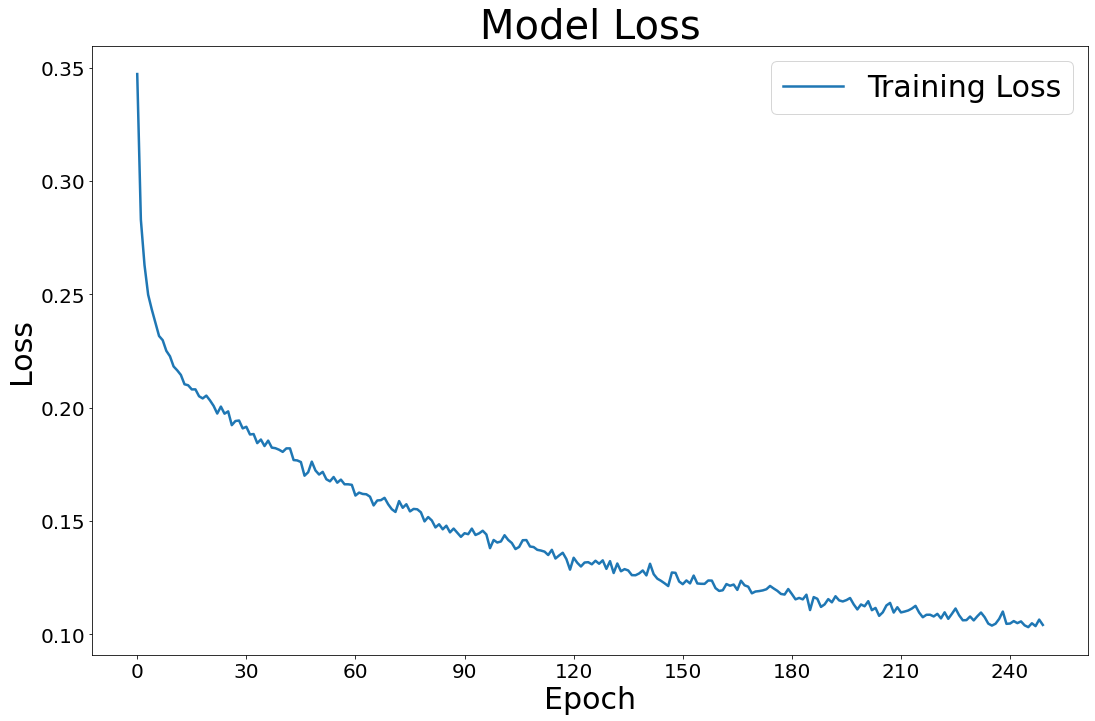

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], linewidth=2.5, label='Training Loss')
plt.legend(loc='best', prop={'size': 30})
plt.title('Model Loss', fontsize=40)
plt.ylabel('Loss', fontsize=30)
plt.xlabel('Epoch', fontsize=30)
ax1 = plt.gca()
plt.tight_layout()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.tick_params(labelsize=20)
plt.show()


In [ ]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/CNN_T_real_time_media_des_atual_reduzido_289.h5')

In [25]:
train_pred = model.predict(trainX_arr, batch_size=1)
train_pred = (train_pred > 0.5).astype(np.int)
train_acc = accuracy_score(Y_train, train_pred)
btrain_acc = balanced_accuracy_score(np.argmax(Y_train, axis=1), np.argmax(train_pred, axis=1))
print('0 1 ')
print(confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(train_pred, axis=1)))
print('Train accuracy:', train_acc)
print('Train balanced accuracy:', btrain_acc)

val_pred = model.predict(valX_arr, batch_size=1)
val_pred = (val_pred > 0.5).astype(np.int)
val_acc = accuracy_score(Y_val, val_pred)
bval_acc = balanced_accuracy_score(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
bconfusion = confusion_matrix(np.argmax(Y_val, axis=1), np.argmax(val_pred, axis=1))
print('0 1')
print(bconfusion)
print('Val accuracy:', val_acc)
print('Val balanced accuracy:', bval_acc)

32014/32014 [==============================] - 64s 2ms/step


<ipython-input-25-e17949272d6f>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_pred = (train_pred > 0.5).astype(np.int)


0 1 
[[15245   762]
 [    5 16002]]
Train accuracy: 0.9760417317423628
Train balanced accuracy: 0.9760417317423626
8002/8002 [==============================] - 16s 2ms/step
0 1
[[3524  477]
 [ 144 3857]]
Val accuracy: 0.9223944013996501
Val balanced accuracy: 0.9223944013996501


<ipython-input-25-e17949272d6f>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  val_pred = (val_pred > 0.5).astype(np.int)


In [26]:
from sklearn.metrics import precision_score, recall_score

print("Precision Score train : ",precision_score(Y_train, train_pred, 
                                           average=None))
print("recall Score train: ", recall_score(Y_train, train_pred, 
                                           average=None))

print("Precision Score val: ",precision_score(Y_val, val_pred, 
                                           average=None))
print("recall Score val: ", recall_score(Y_val, val_pred, 
                                           average=None))

Precision Score train :  [0.99967213 0.95454545]
recall Score train:  [0.95239583 0.99968764]
Precision Score val:  [0.96074155 0.88994001]
recall Score val:  [0.88077981 0.964009  ]


In [24]:
model.save('/content/drive/MyDrive/CNN_T_real_time_media_des_GAN_simetrico.h5')

# from keras.models import load_model

# model.load_weights('/content/drive/MyDrive/CNN_T_94_81_V_94_78.h5')


In [ ]:
def plot_graf(Train_datafreqT,ev,label,first):
    name_file = '/content/drive/MyDrive/Val_events_V3_FP.html';
    events = list()
    me = list()
    soma = 0
    qtd = 0

    trainXi = Train_datafreqT
    trainXi = pd.DataFrame.from_dict(trainXi)
    
    name_columns = trainXi.columns
    
    for i in range (0,pd.DataFrame.from_dict(trainXi).shape[1]):
        
        y = trainXi.iloc[0:,i].values
       
        trace1 = {

        "fill": "none", 
        "line": {
          "dash": "solid",  
          "shape": "linear", 
          "width": 2
        }, 
        "name": name_columns[i], 
        "type": "scatter",  
        "y": y, 
        "opacity": 1, 
        }

        events.append(trace1)


    # configurar o layout do gráfico
    layout = go.Layout({
      'title': {
          'text': 'Recording r=' + str(ev) + 'Label: '+label,
          'font': {
              'size': 20
          }
      }          
    }

    )


    fig = go.Figure(data=events, layout=layout)
#     fig.show()

    fig_json = fig.to_json()
    
    if(first == True):
        first = False
        template = """<html>
            <head>
                <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            </head>
            <body>
                <div id="""+ str(ev) +"""></div>
                <script>
                    var plotly_data = {}
                    Plotly.react('"""+ str(ev) +"""', plotly_data.data, plotly_data.layout);
                </script>

            """
        with open(name_file, 'a') as f:
            f.write(template.format(fig_json))
    else:
        temp = """<div id="""+ str(ev) +"""></div>
            <script>
                var plotly_data = {}
                Plotly.react('"""+ str(ev) +"""', plotly_data.data, plotly_data.layout);
            </script>"""
        with open(name_file, 'a') as f:
            f.write(temp.format(fig_json))
    return first

In [ ]:
import plotly.graph_objects as go

first = True
for k in range(500,len(val_pred)):
    
    if (np.argmax(val_pred[k],axis=0) == 1) & (np.argmax(Y_val[k],axis=0) == 0):
#         print('pred: ', test_pred[k])
#         print('label: ', Y_test[k])
        
        testXi = pd.DataFrame.from_dict(valX_arr[k, :,:,0])

        first = plot_graf(testXi,k,str(np.argmax(Y_val[k],axis=0)),first)
        

In [ ]:
# for k in range(0,len(train_pred)):
    
#     if (np.argmax(trainX_arr[k],axis=0) == 0) & (np.argmax(Y_train[k],axis=0) == 0):
# #         print('pred: ', test_pred[k])
# #         print('label: ', Y_test[k])
        
#         testXi = pd.DataFrame.from_dict(testX_arr[k, :,:,0])
#         print(testXi.shape)
        
# print(testXi.shape[1])

ValueError: ignored

In [ ]:
import plotly.graph_objects as go
name_file = 'Train_events_L1_p0.html';
first = True



for k in range(0,2400):
    
    if  (np.argmax(test_pred[k],axis=0) == 1) & (np.argmax(Y_test[k],axis=0) == 0):
#         print('pred: ', test_pred[k])
#         print('label: ', Y_test[k])
        
        testXi = pd.DataFrame.from_dict(testX_arr[k, :,:,0])
        testXi = testXi+60
#         testXi.plot(figsize=(15, 10), legend=True)
#         plt.title('Event ev=' + str(k), fontsize=40)
#         plt.show()
        events = list()
   
        for i in range (0,testXi.shape[1]):
            trace1 = {

            "fill": "none", 
            "line": {
              "dash": "solid",  
              "shape": "linear", 
              "width": 2
            }, 
    #         "name": name_columns[i], 
            "type": "scatter",  
            "y": testXi.iloc[0:,i], 
            "opacity": 1, 
            }

            events.append(trace1)


        # configurar o layout do gráfico
        layout = go.Layout({
          'title': {
              'text': 'Event ev=' + str(k),
              'font': {
                  'size': 20
              }
          }          
        }

        )


        fig = go.Figure(data=events, layout=layout)

        fig_json = fig.to_json()

        if(first == True):
            first = False
            template = """<html>
                <head>
                    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
                </head>
                <body>
                    <div id="""+ str(k) +"""></div>
                    <script>
                        var plotly_data = {}
                        Plotly.react('"""+ str(k) +"""', plotly_data.data, plotly_data.layout);
                    </script>

                """
            with open(name_file, 'a') as f:
                f.write(template.format(fig_json))
        else:
            temp = """<div id="""+ str(k) +"""></div>
                <script>
                    var plotly_data = {}
                    Plotly.react('"""+ str(k) +"""', plotly_data.data, plotly_data.layout);
                </script>"""
            with open(name_file, 'a') as f:
                f.write(temp.format(fig_json))




NameError: name 'np' is not defined

In [ ]:

for k in range(0,len(test_pred)):
     if (np.argmax(test_pred[k],axis=1) == 0) & (np.argmax(Y_test[k],axis=1) == 1):
#         print('pred: ', test_pred[k])
#         print('label: ', Y_test[k])
        
        testXi = pd.DataFrame.from_dict(testX_arr[k, :,:,0].T)
        testXi.plot(figsize=(15, 10), legend=True)
        plt.title('Event ev=' + str(k), fontsize=40)
        plt.show()
